In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing as ES
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf

from pmdarima import auto_arima
import statsmodels.api as sm

import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

from glob import glob

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Generate resampled daily data

def sample_daily(customer_file):
    """This function creates daily data for all customer-sites from the hourly energy consumption data"""
    
    df = pd.read_csv(customer_file, parse_dates = ['Start Time'])
    df.set_index('Start Time', inplace = True)
    df['Date'] = df.index
    customer_name = str(customer_file[:-15])
    
    site_id = df['Site ID'].unique()
    site_name = df['Site Name'].unique()

    resultsdf = pd.DataFrame(columns = ['Site', 'Site Name', 'Energy Consumption (kWh)'])
    results = pd.DataFrame(columns = ['Site', 'Site Name', 'Energy Consumption (kWh)'])
    for i in range(0, len(site_id)):
        
        resultsdf['Energy Consumption (kWh)'] = df['Sum'][df['Site ID'] == site_id[i]].resample('D').sum()
        resultsdf['Site'] = df['Site ID'][df['Site ID'] == site_id[i]].resample('D').first()
        resultsdf['Site Name'] = df['Site Name'][df['Site Name'] == site_name[i]].resample('D').first()
        results = results.append(resultsdf)
        results['Date'] = results.index      
 
    return results

In [ ]:
#CUSTOMIZABLE BLOCK

#User input: Raw kWh report csv file (/data/raw/kWh Reports/)
#data_daily = sample_daily('')

#Save the daily data as csv
#data_daily.to_csv('Caliber_Daily.csv')

In [2]:
def read_file(customer_file, site_id):
    """This function generates dataframe for a site with corresponding customer name"""
    
    df = pd.read_csv(customer_file)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.set_index(df['Date'])
    
    customer_name = str(customer_file[0:-10])
    dff = df.loc[df['Site'] == site_id]
    
    return customer_name, site_id, dff


#Inputs
customer_name, site_id, data_daily = read_file('Caliber_Daily.csv', 'CCC0611')

In [3]:
#Check site average energy consumption for given timeframe

y = round(np.mean(data_daily['Energy Consumption (kWh)']), 2)
print("Average energy consumption (kWh) =", y)

Average energy consumption (kWh) = 586.57


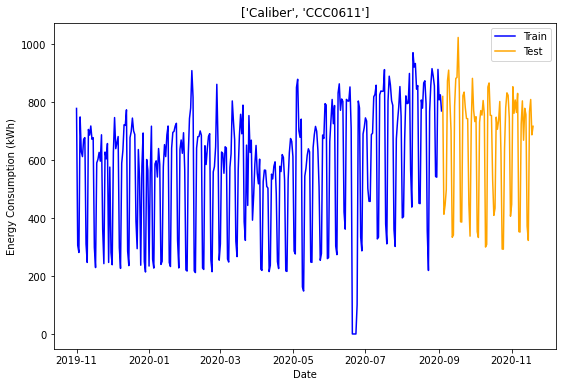

In [4]:
def split_data(dataseries, column_name):
    """This function splits time-series data into train & test datasets and plots them"""
    
    min_value, max_value = dataseries['Date'].min(), dataseries['Date'].max()
    
    #make it a suitable 80% - 20% split
    train = dataseries[column_name].loc[min_value:'2020-09-03']
    test = dataseries[column_name].loc['2020-09-04':'2020-11-19']
    
    plt.figure(figsize = (9, 6))
    plt.plot(train, color = 'b')
    plt.title([customer_name, site_id])
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption (kWh)')
    plt.plot(test, color = 'orange')
    plt.legend(['Train', 'Test'])
    
    return train, test, plt.show()


#User input: Time-series data & univariate series name

train, test, plot = split_data(data_daily, 'Energy Consumption (kWh)')

In [5]:
#Check test ratio

print("#Train=", len(train))
print("#Test=", len(test)) 
print("Test % =", round(((len(test)/len(data_daily))*100), 2))

#Train= 308
#Test= 77
Test % = 19.95


# Simple Moving Average

In [6]:
#Create MA model (rolling window = 7 days)

window_size = 7
hist = [train[i] for i in range(len(train))]
pred0 = []
for t in range(len(test)):
    yhat = np.mean(hist[-(window_size)])
    obs = test.iloc[t]
    pred0.append(yhat)
    hist.append(obs)


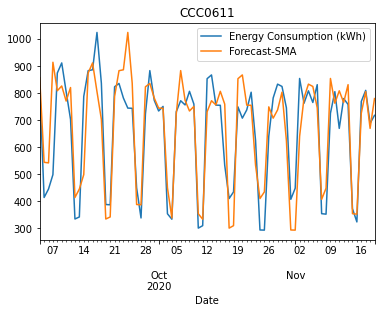

In [7]:
def model_output(predicted_data):
    """This plots test and predicted datasets for a visual comparison"""
    
    forecast_data = pd.DataFrame(predicted_data, index = test.index, columns = ['Forecast-SMA'])
    output = pd.concat([test, forecast_data], axis = 1)
    
    return output.plot(title = site_id), output


#User input: Forecasted dataset
plot0, resultsdf0 = model_output(pred0)

In [8]:
def check_error(orig, fore):
    """This function generates performance metrics"""
    
    mse = mean_squared_error(orig, fore)
    rmse = round(sqrt(mse), 2)
    mape = round(np.mean(np.abs((orig - fore) / orig)) * 100, 2)
    metrics = [rmse, mape]
    
    return metrics[0], metrics[1]


def plot_error(output_data):
    """This generates residual graphs"""
    
    plt.figure(figsize = (15, 10))
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))   
    
    ## QQ-plot of the residual
    sm.graphics.qqplot(output_data.iloc[:, 2], line = 'r', ax = ax1)
    
    # Autocorrelation plot of the residual
    plot_acf(output_data.iloc[:, 2], lags = len(output_data.iloc[:, 2])-1, zero = False, ax = ax2)
    
    return plt.show()


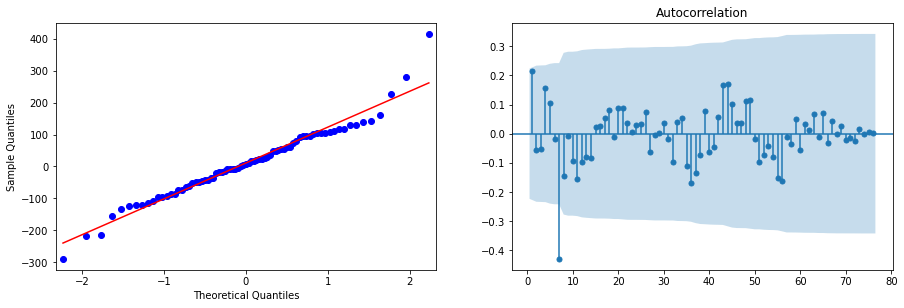

In [9]:
#Create error column, then plot errors

resultsdf0['Error'] = resultsdf0['Forecast-SMA'] - resultsdf0['Energy Consumption (kWh)']
#resultsdf0.to_csv('')

#Inputs
rmse0, mape0 = check_error(test, pred0)
plot_error(resultsdf0)

In [10]:
#Create model summary dataframe

errordf = pd.DataFrame(columns = ['Site ID', 'Region', 'Test ratio', 'Forecast Model', 'RMSE','MAPE'])

In [11]:
#change region in accordance with site ID

m0 = resultsdf0.columns[1][9:]

df0 = errordf.append({'Site ID': site_id,'Region': 'US-TX', 'Test ratio':'20%', 'Forecast Model': m0,'RMSE': rmse0, 'MAPE': mape0}, 
                     ignore_index = True)
df0

,Site ID,Region,Test ratio,Forecast Model,RMSE,MAPE
0,CCC0611,US-TX,20%,SMA,110.14,14.52


# Exponential Smoothing

In [12]:
#Create SE model with a smoothing parameter (lag = 1 period)

alpha = 1.0
hist = [train[i] for i in range(len(train))]
hist_pred = [train.iloc[i] for i in range(len(train))]
pred1 = []
for t in range(len(test)):
    yhat = hist_pred[-1] + alpha*(hist[-1] - hist_pred[-1])
    obs = test.iloc[t]
    pred1.append(yhat)
    hist.append(obs)
    hist_pred.append(yhat)


In [13]:
#Print model summary

model = ES(train).fit(smoothing_level = alpha)
print(model.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                  308
Model:             ExponentialSmoothing   SSE                       16531979.453
Optimized:                         True   AIC                           3358.338
Trend:                             None   BIC                           3365.798
Seasonal:                          None   AICC                          3358.470
Seasonal Periods:                  None   Date:                 Tue, 15 Dec 2020
Box-Cox:                          False   Time:                         17:08:58
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                False
initial_level              778.620

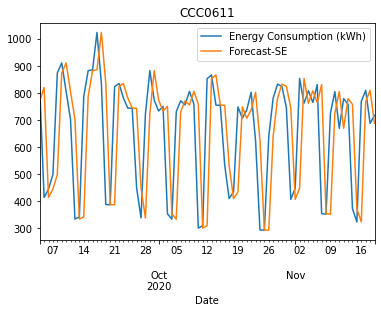

In [14]:
def model_output(predicted_data):
    """This plots test and predicted datasets for a visual comparison"""
    
    forecast_data = pd.DataFrame(predicted_data, index = test.index, columns = ['Forecast-SE'])
    output = pd.concat([test, forecast_data], axis = 1)
    
    return output.plot(title = site_id), output


#User input: Forecasted dataset
plot1, resultsdf1 = model_output(pred1)

In [15]:
def check_error(orig, fore):
    """This function generates performance metrics"""
    
    mse = mean_squared_error(orig, fore)
    rmse = round(sqrt(mse), 2)
    mape = round(np.mean(np.abs((orig - fore) / orig)) * 100, 2)
    metrics = [rmse, mape]
    
    return metrics[0], metrics[1]


def plot_error(output_data):
    """This generates residual graphs"""
    
    plt.figure(figsize = (15, 10))
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1))   
    
    ## QQ-plot of the residual
    sm.graphics.qqplot(output_data.iloc[:, 2], line = 'r', ax = ax1)
    
    # Autocorrelation plot of the residual
    plot_acf(output_data.iloc[:, 2], lags = len(output_data.iloc[:, 2])-1, zero = False, ax = ax2)
    
    return plt.show()


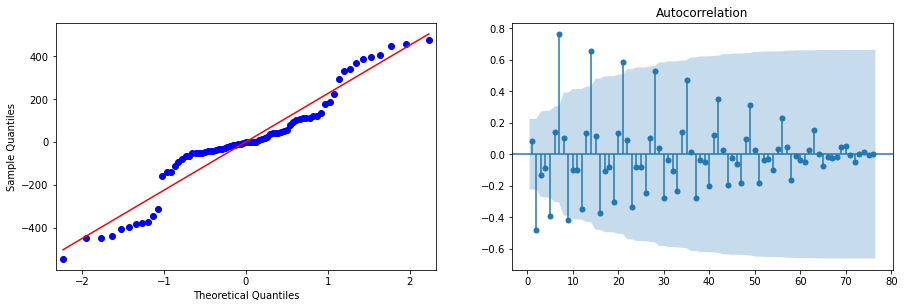

In [16]:
#Create error column, then plot errors

resultsdf1['Error'] = resultsdf1['Forecast-SE'] - resultsdf1['Energy Consumption (kWh)']
#resultsdf1.to_csv('')

#Inputs
rmse1, mape1 = check_error(test, pred1)
plot_error(resultsdf1)

In [17]:
m1 = resultsdf1.columns[1][9:]

df1 = df0.append({'Site ID': site_id,'Region': 'US-TX', 'Test ratio':'20%', 'Forecast Model': m1,'RMSE': rmse1, 'MAPE': mape1}, 
                     ignore_index = True)
df1

,Site ID,Region,Test ratio,Forecast Model,RMSE,MAPE
0,CCC0611,US-TX,20%,SMA,110.14,14.52
1,CCC0611,US-TX,20%,SE,221.77,28.51


# ARIMA

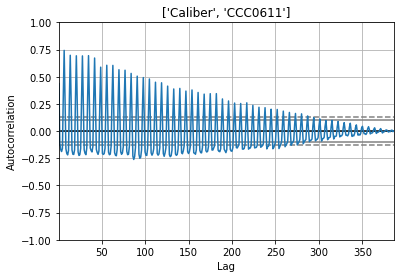

In [18]:
def data_AC(column_name):
    """This function finds auto-correlation of the univariate series"""
    
    y = data_daily[column_name]
    pd.plotting.autocorrelation_plot(y)
    plt.title([customer_name, site_id])
    
    return plt.show()


#User input: Univariate series name
data_AC('Energy Consumption (kWh)')

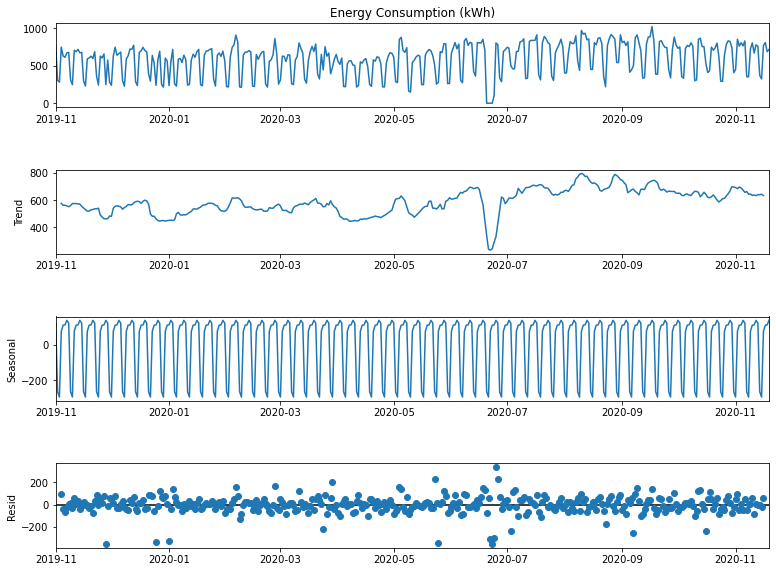

In [19]:
def data_decomposition(dataseries, freq):
    """This function plots components of the dataset"""
    
    result = seasonal_decompose(dataseries, period = freq)
    fig = result.plot().set_size_inches(12, 9)
    return fig


#User inputs: Data & series frequency
data_decomposition(train.append([test]), 7)

In [20]:
#Series stationarity tests

def adfuller_test(dataseries):
    """This checks data stationarity (Dickey-Fuller Test) and prints the reults"""
    
    adf = adfuller(dataseries)
    output = pd.Series(adf[0:4], index = ['ADF Statistic', 'p-value', 'Lags', '#comments used'])
    for key, value in adf[4].items():
        output["Critical Value (%s)" %key] = value
    
    return print(output)


def kpss_test(dataseries):
    """This checks data stationarity (KPSS Test) and prints the results"""
    
    kpss_input = kpss(dataseries)
    output = pd.Series(kpss_input[0:3], index = ['KPSS Statistic', 'p-value', 'Lags'])
    
    for key, value in kpss_input[3].items():
        output["Critical Value (%s)" %key] = value 
    
    return print(output)


#User input: Training data
adfuller_test(train)
kpss_test(train)
print('\n')
print('First-differenced Train set:')
adfuller_test(train.diff().dropna())
kpss_test(train.diff().dropna())

ADF Statistic            -2.694971
p-value                   0.074912
Lags                     14.000000
#comments used          293.000000
Critical Value (1%)      -3.452867
Critical Value (5%)      -2.871455
Critical Value (10%)     -2.572053
dtype: float64
KPSS Statistic            0.806093
p-value                   0.010000
Lags                     16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


First-differenced Train set:
ADF Statistic          -6.505014e+00
p-value                 1.136884e-08
Lags                    1.300000e+01
#comments used          2.930000e+02
Critical Value (1%)    -3.452867e+00
Critical Value (5%)    -2.871455e+00
Critical Value (10%)   -2.572053e+00
dtype: float64
KPSS Statistic            0.042639
p-value                   0.100000
Lags                     16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000


In [21]:
def order_parameters(training_data):
    """This performs a grid search for best model parameters; use kpss test for optimal D"""
    
    search_params = auto_arima(train, start_p = 0, start_q = 0, m = 7, seasonal = True, test = "adf", d = None, D = 1, trace = True, information_criterion = "aic", alpha = 0.05,  
                               error_action = 'ignore', suppress_warnings = True, stepwise = True)
    
    print("AIC = ", round(search_params.aic(), 2))
    print("BIC = ", round(search_params.bic(), 2))
    return search_params


#User input: Train set
model = order_parameters(train)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=3906.895, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=3732.999, Time=0.22 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=3905.095, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=3795.063, Time=0.11 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=3702.022, Time=0.52 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.30 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=3822.485, Time=1.10 sec
 ARIMA(2,0,0)(2,1,0)[7] intercept   : AIC=3704.013, Time=0.63 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=3704.011, Time=0.55 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=3729.767, Time=0.72 sec
 ARIMA(2,0,1)(2,1,0)[7] intercept   : AIC=inf, Time=1.78 sec
 ARIMA(1,0,0)(2,1,0)[7]             : AIC=3700.204, Time=0

In [22]:
def train_model(training_data, p, d, q, P, D, Q, m):
    """This executes model training and prints model summary"""
    
    mod = sm.tsa.arima.ARIMA(training_data, order = (p, d, q), seasonal_order = (P, D, Q, m))
    model_fit = mod.fit()
    return model_fit, print(model_fit.summary().tables[0], model_fit.summary().tables[1])


#User inputs: Training data & parameters found from grid search

model_fit, summary = train_model(train, 1, 0, 0, 0, 1, 1, 7)

                                     SARIMAX Results                                     
Dep. Variable:          Energy Consumption (kWh)   No. Observations:                  308
Model:             ARIMA(1, 0, 0)x(0, 1, [1], 7)   Log Likelihood               -1821.467
Date:                           Tue, 15 Dec 2020   AIC                           3648.935
Time:                                   17:10:12   BIC                           3660.056
Sample:                               11-01-2019   HQIC                          3653.385
                                    - 09-03-2020                                         
Covariance Type:                             opg                                         
========================================================================================= ==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [23]:
def test_model(test_data):
    """This executes model testing"""
    
    output_data = model_fit.get_forecast(steps = len(test_data), alpha = 0.05) #default 95% CI
    pred_data = output_data.predicted_mean
    return pred_data


#User input: Test set
pred2 = test_model(test)

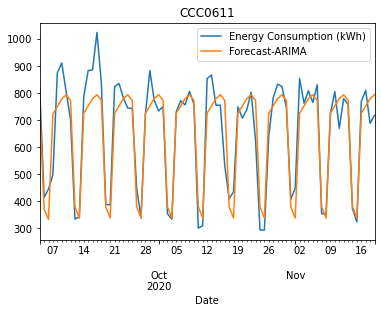

In [24]:
def model_output(predicted_data):
    """This plots test and predicted datasets for a visual comparison"""
    
    forecast_data = pd.DataFrame(predicted_data, index = test.index, columns = ['Forecast-ARIMA'])
    output = pd.concat([test, forecast_data], axis = 1)
    
    return output.plot(title = site_id), output


#User input: Forecasted dataset
plot2, resultsdf2 = model_output(pred2)

In [25]:
def check_error(orig, fore):
    """This function generates performance metrics"""
    
    mse = mean_squared_error(orig, fore)
    rmse = round(sqrt(mse), 2)
    mape = round(np.mean(np.abs((orig - fore) / orig)) * 100, 2)
    metrics = [rmse, mape]
    
    return metrics[0], metrics[1]


def plot_error(output_data):
    """This generates residual graphs"""
    
    plt.figure(figsize = (15, 10))
    ax1 = plt.subplot2grid((2,2), (0,0))
    ax2 = plt.subplot2grid((2,2), (0,1)) 
    
    ## QQ-plot of the residual
    sm.graphics.qqplot(output_data.iloc[:, 2], line = 'r', ax = ax1)
    
    # Autocorrelation plot of the residual
    plot_acf(output_data.iloc[:, 2], lags = len(output_data.iloc[:, 2])-1, zero = False, ax = ax2)
       
    return plt.show()

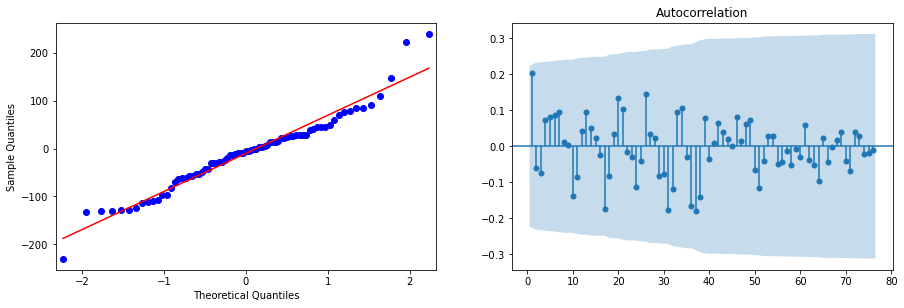

In [26]:
#Create error column, then plot errors

resultsdf2['Error'] = resultsdf2['Forecast-ARIMA'] - resultsdf2['Energy Consumption (kWh)']
#resultsdf2.to_csv('')

#Inputs
rmse2, mape2 = check_error(test, pred2)
plot_error(resultsdf2)

In [27]:
#Append results to summary dataframe; check-in data stationarity column as well

m2 = resultsdf2.columns[1][9:]

df2 = df1.append({'Site ID':site_id,'Region': 'US-TX', 'Test ratio':'20%', 'Forecast Model': m2,'RMSE':rmse2, 'MAPE':mape2, 'Series Stationary-Y/N?': 'N'},
                 ignore_index = True)
df2

,Site ID,Region,Test ratio,Forecast Model,RMSE,MAPE,Series Stationary-Y/N?
0,CCC0611,US-TX,20%,SMA,110.14,14.52,NaN
1,CCC0611,US-TX,20%,SE,221.77,28.51,NaN
2,CCC0611,US-TX,20%,ARIMA,78.44,9.38,N


# Model Comparison & Output Dataframe

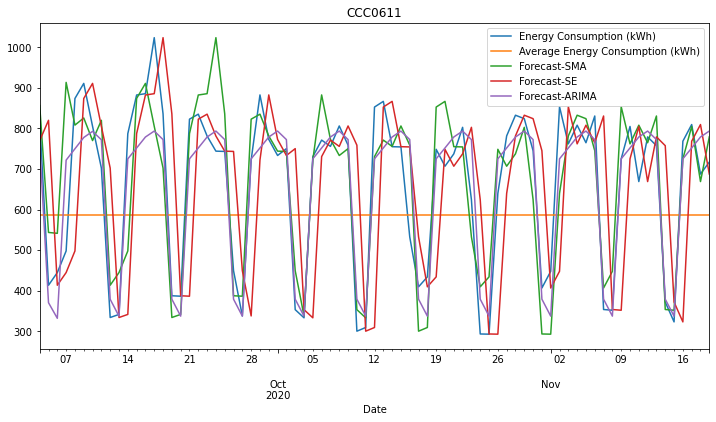

In [28]:
def model_output(predicted_data0, predicted_data1, predicted_data2):
    """This plots test & predicted datasets for a visual comparison of the models"""
    
    forecast_data0 = pd.DataFrame(predicted_data0, index = test.index, columns = ['Forecast-SMA'])
    forecast_data1 = pd.DataFrame(predicted_data1, index = test.index, columns = ['Forecast-SE'])
    forecast_data2 = pd.DataFrame(predicted_data2, index = test.index, columns = ['Forecast-ARIMA'])
    
    avg_consumption = pd.DataFrame(y, index = test.index, columns = ["Average Energy Consumption (kWh)"])
    site = pd.DataFrame(site_id, index = test.index, columns = ["Site ID"])
    output = pd.concat([site, test, avg_consumption, forecast_data0, forecast_data1, forecast_data2], axis = 1)
    
    return output.plot(title = site_id, figsize = (12, 6)), output


#User input: Forecasted datasets
plot, resultsdf = model_output(pred0, pred1, pred2)

In [29]:
resultsdf.head()

,Site ID,Energy Consumption (kWh),Average Energy Consumption (kWh),Forecast-SMA,Forecast-SE,Forecast-ARIMA
Date,,,,,,
2020-09-04,CCC0611,819.86,586.57,856.30,769.90,758.075235
2020-09-05,CCC0611,413.30,586.57,543.45,819.86,370.243891
2020-09-06,CCC0611,444.56,586.57,541.27,413.30,331.846899
2020-09-07,CCC0611,497.83,586.57,913.32,444.56,721.690398
2020-09-08,CCC0611,873.69,586.57,808.05,497.83,749.702267


In [30]:
#Save site results to csv files

#resultsdf.to_csv('results_CCC4103.csv')
#resultsdf.to_csv('results_CCC2009.csv')
#resultsdf.to_csv('results_CCC1059.csv')
#resultsdf.to_csv('results_CCC0543.csv')
#resultsdf.to_csv('results_CCC0501.csv')
#resultsdf.to_csv('results_CCC0611.csv')

#Load site output files as dataframes

filenames = glob('results*.csv')
dataframe = [pd.read_csv(f) for f in filenames]

In [45]:
#Write big output (all sites) in csv file

big_frame = pd.concat(dataframe, ignore_index = True)
#big_frame.to_csv('CCC_output.csv')